In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from scipy import misc
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('.\code')

update lib

In [4]:
!git clone https://urandon@bitbucket.org/urandon/ccas.py.git ccas_py

fatal: destination path 'ccas_py' already exists and is not an empty directory.


In [3]:
import ccas_py
from ccas_py import utils, trainer, inspector, classifier, storage
reload(classifier), reload(trainer), reload(inspector), reload(utils)

(<module 'ccas_py.classifier' from 'ccas_py/classifier.pyc'>,
 <module 'ccas_py.trainer' from 'ccas_py/trainer.pyc'>,
 <module 'ccas_py.inspector' from 'ccas_py/inspector.pyc'>,
 <module 'ccas_py.utils' from 'ccas_py/utils.pyc'>)

In [4]:
import gc
gc.collect()

34

# Load data from network

In [4]:
# update : the link is expired
!wget http://urandon.moy.su/load/0-0-0-5-20 -O ./data/input.txt

--2015-12-29 19:27:23--  http://urandon.moy.su/load/0-0-0-5-20
Resolving urandon.moy.su (urandon.moy.su)... 195.216.243.122
Connecting to urandon.moy.su (urandon.moy.su)|195.216.243.122|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://urandon.moy.su/_ld/0/5_input.txt [following]
--2015-12-29 19:27:23--  http://urandon.moy.su/_ld/0/5_input.txt
Reusing existing connection to urandon.moy.su:80.
HTTP request sent, awaiting response... 200 OK
Length: 12062119 (12M) [text/plain]
Saving to: './data/input.txt'

100%[======================================>] 12,062,119  39.4MB/s   in 0.3s   

2015-12-29 19:27:24 (39.4 MB/s) - './data/input.txt' saved [12062119/12062119]



# Split data (input.txt) to train + recog

In [10]:
df = pd.read_csv('./data/input.txt', index_col=0)

In [11]:
target = df['target']

In [12]:
class_labels = unique(target.values)
class_labels

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

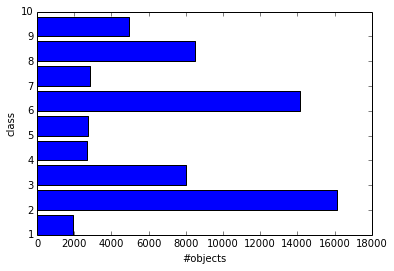

In [13]:
barh(class_labels, [sum(target == label) for label in class_labels])
xlabel('#objects')
ylabel('class')
show()

In [8]:
np.random.seed(1756412934)

In [9]:
class_shuffle = {}
rec_idx, train_idx = [], []
for label in class_labels:
    cidx = list(nonzero(target == label)[0])
    shuffle(cidx)
    n = len(cidx)
    train_idx += cidx[:n/10]
    rec_idx += cidx[n/10:]
    class_shuffle[label] = cidx
rec_idx.sort()
train_idx.sort()

In [11]:
df_rec = df.iloc[rec_idx]
df_train = df.iloc[train_idx]
df_rec.shape, df_train.shape

((55695, 94), (6183, 94))

In [12]:
with open('data/recog.tab', 'w') as fo:
    df_rec.to_csv(fo, index_label='id')

In [13]:
with open('data/train.tab', 'w') as fo:
    df_train.to_csv(fo, index_label='id')

In [14]:
import hashlib
for filename in ['data/recog.tab', 'data/train.tab']:
    print filename + ': ' +hashlib.md5(open(filename, 'rb').read()).hexdigest()

data/recog.tab: 6073060971176d18bf69bcb2eb082bea
data/train.tab: 36863b7fced4bdc22aed7e7f01de72d3


# Load the data

In [5]:
filename = './data/train.tab'

In [6]:
df = pd.read_csv(filename, index_col=0)

In [7]:
df_train = df

In [8]:
df.shape

(6183, 94)

In [8]:
target = df['target']
class_labels = unique(target.values)

In [10]:
import gc
gc.collect()

9

In [9]:
y_multi = array(df['target'])

In [10]:
X = np.double(df.drop('target', axis=1).as_matrix())

read rec df

In [11]:
df_rec = pd.read_csv('./data/recog.tab', index_col=0)

In [12]:
df_rec.shape

(55695, 94)

In [15]:
y_multi_rec = array(df_rec['target'])

In [16]:
X_rec = np.double(df_rec.drop('target', axis=1).as_matrix())

load dataframe with new features

In [29]:
df_rec_new = pd.read_csv('./data/recog_new.tab', index_col=0)

# Train multiclass problem

In [14]:
best = {}
for goal_label in class_labels:
    tr = trainer.MaxCorrelationTrainer(comparision_threshold=0.999,
                                       parallel_profile='threads-16')
    print 'Working {} vs ALL'.format(goal_label)
    train_sample_1vsall = utils.Sample(X, (y_multi == goal_label) * 1)
    nnc = tr.train(train_sample_1vsall)
    best[goal_label] = utils.top_combos(nnc, k=40)

Running parallel in 16 threads
Working 1 vs ALL
Best pearson (1):  0.184
pairs found = 4112
Best pearson (2):  0.236
	combinations to process: 81
Best pearson (3):  0.247
	combinations to process: 80
Best pearson (4):  0.253
	combinations to process: 21
Best pearson (5):  0.257
	combinations to process: 27
Best pearson (6):  0.265
	combinations to process: 81
Best pearson (7):  0.271
	combinations to process: 88
Best pearson (8):  0.276
	combinations to process: 81
Best pearson (9):  0.280
	combinations to process: 41
Best pearson (_):  0.280
Best combination: 16; 24; 29; 53; 54; 57; 59; 66; 83
Weights: 0.0886083807068; 0.126210091268; 0.0164226316513; 0.130713021299; 0.0748592985255; 0.213695789173; 0.206126108546; 0.0570475469799; 0.0863171318508
Running parallel in 16 threads
Working 2 vs ALL
Best pearson (1):  0.349
pairs found = 4193
Best pearson (2):  0.422
	combinations to process: 94
Best pearson (3):  0.447
	combinations to process: 108
Best pearson (4):  0.466
	combinations t

In [17]:
all_nnc = {}
for goal_label in class_labels:
    tr = trainer.MaxCorrelationTrainer(comparision_threshold=0.999,
                                       parallel_profile='threads-16')
    print 'Working {} vs ALL'.format(goal_label)
    train_sample_1vsall = utils.Sample(X, (y_multi == goal_label) * 1)
    nnc = tr.train(train_sample_1vsall)
    all_nnc[goal_label] = nnc

Running parallel in 16 threads
Working 1 vs ALL
Best pearson (1):  0.184
pairs found = 4112
Best pearson (2):  0.236
	combinations to process: 81
Best pearson (3):  0.247
	combinations to process: 80
Best pearson (4):  0.253
	combinations to process: 21
Best pearson (5):  0.257
	combinations to process: 27
Best pearson (6):  0.265
	combinations to process: 81
Best pearson (7):  0.271
	combinations to process: 88
Best pearson (8):  0.276
	combinations to process: 81
Best pearson (9):  0.280
	combinations to process: 41
Best pearson (_):  0.280
Best combination: 16; 24; 29; 53; 54; 57; 59; 66; 83
Weights: 0.0886083807068; 0.126210091268; 0.0164226316513; 0.130713021299; 0.0748592985255; 0.213695789173; 0.206126108546; 0.0570475469799; 0.0863171318508
Running parallel in 16 threads
Working 2 vs ALL
Best pearson (1):  0.349
pairs found = 4193
Best pearson (2):  0.422
	combinations to process: 94
Best pearson (3):  0.447
	combinations to process: 108
Best pearson (4):  0.466
	combinations t

# Save combinations

In [16]:
import cPickle as pickle

In [20]:
with open('data/best_combinations.pickle', 'wb') as fo:
    pickle.dump(best, fo)

In [36]:
with open('data/best_combinations.txt', 'wb') as fo:
    for (label, best_for_label) in best.iteritems():
        fo.write('Label {} vs ALL\n:'.format(label))
        fo.write(''.join([
            'combo: {}\tfunc = {}\tweights: {}\n'.
                format(best_label_combo[0], *best_label_combo[1])
                for best_label_combo in best_for_label]))
        fo.write('\n')

In [18]:
import cPickle as pickle
with open('data/all_combinations.pickle', 'wb') as fo:
    pickle.dump(all_nnc, fo)

In [19]:
print 'foo'

foo


In [21]:
{label: len(all_nnc[label]) for label in class_labels}

{1: 593, 2: 7101, 3: 583, 4: 224, 5: 349499, 6: 1649, 7: 308, 8: 414, 9: 269}

In [44]:
sum([len(all_nnc[label]) for label in class_labels if label != 5 and label != 2])

4040

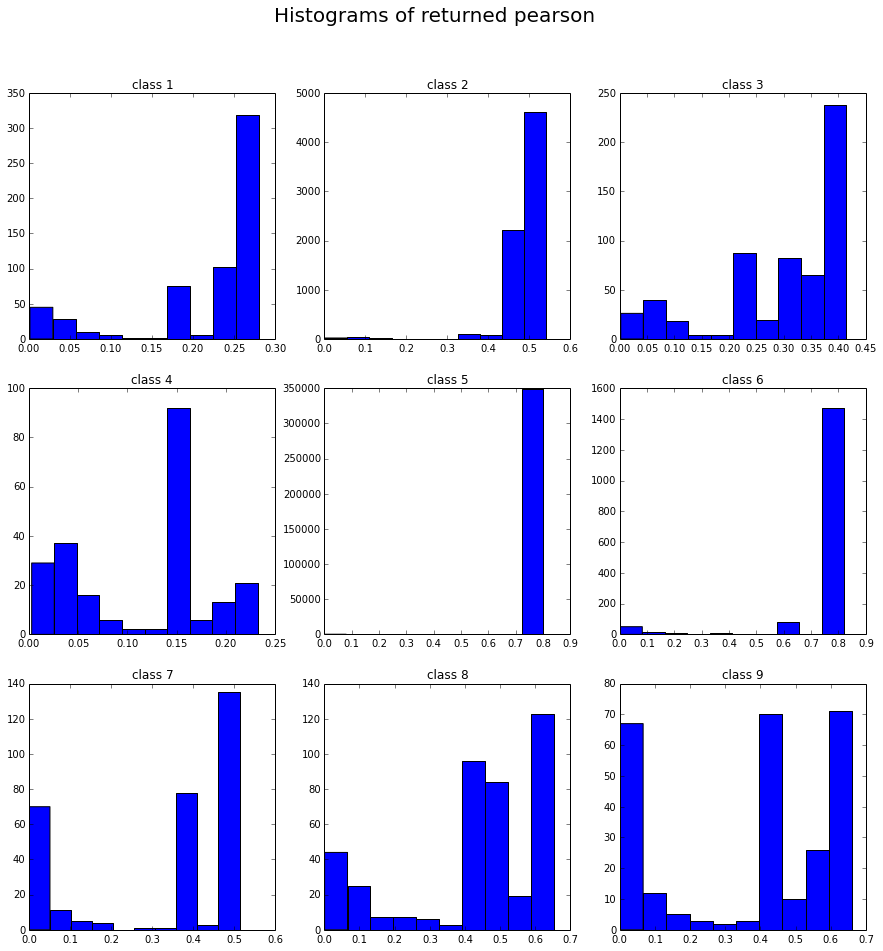

In [40]:
fig = figure(figsize=(15, 15))
fig.suptitle('Histograms of returned pearson', fontsize=20)
for label in class_labels:
    subplot(3, 3, label)
    hist([f for (c, (f, w)) in all_nnc[label]])
    title('class {}'.format(label))
show()

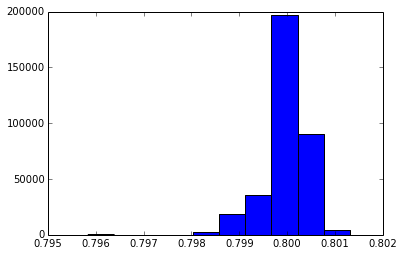

In [48]:
hist([f for (c, (f, w)) in all_nnc[5] if f > 0.2])
show()

# Load combinations

In [30]:
import cPickle as pickle

In [31]:
with open('data/best_combinations.pickle', 'rb') as fi:
    best = pickle.load(fi)

# Make new featues

In [50]:
top_k = 80
best = {}
for goal_label in class_labels:    
    best[goal_label] = utils.top_combos(all_nnc[goal_label], k=top_k)

In [65]:
# make features on rec data
combo_features = {}
gen = trainer.FeatureGenerator()
for goal_label in class_labels:
    print 'Working {} vs ALL'.format(goal_label)
    train_sample_1vsall = utils.Sample(X, (y_multi == goal_label) * 1)
    recog_sample_1vsall = utils.Sample(X_rec, (y_multi_rec == goal_label) * 1)
    combo_features[goal_label] = gen.from_combinations(train_sample_1vsall,
                                                      recog_sample_1vsall,
                                                      best[goal_label])

Working 1 vs ALL
Working 2 vs ALL
Working 3 vs ALL
Working 4 vs ALL
Working 5 vs ALL
Working 6 vs ALL
Working 7 vs ALL
Working 8 vs ALL
Working 9 vs ALL


In [66]:
len(best[1]), combo_features[1].shape

(80, (55695, 80))

make dataframe with new features

In [67]:
df_new = {}
for goal_label in class_labels:
    df_new[goal_label] = pd.DataFrame(
        {'combo_{}_{:02d}'.format(goal_label, idx) :
         combo_features[goal_label][:,idx]
         for idx in xrange(combo_features[goal_label].shape[1])},
        index=df_rec.index)

In [68]:
frames = [df_rec] + df_new.values()

In [69]:
df_rec_new = pd.concat(frames, axis=1)

In [70]:
target_idx = 93
cols = df_rec_new.columns

In [71]:
df_rec_new = df_rec_new[sorted(cols)]

In [59]:
# make features on train data
combo_features = {}
gen = trainer.FeatureGenerator()
for goal_label in class_labels:
    print 'Working {} vs ALL'.format(goal_label)
    train_sample_1vsall = utils.Sample(X, (y_multi == goal_label) * 1)
    combo_features[goal_label] = gen.from_combinations(train_sample_1vsall,
                                                      train_sample_1vsall,
                                                      best[goal_label])

Working 1 vs ALL
Working 2 vs ALL
Working 3 vs ALL
Working 4 vs ALL
Working 5 vs ALL
Working 6 vs ALL
Working 7 vs ALL
Working 8 vs ALL
Working 9 vs ALL


In [60]:
df_new = {}
for goal_label in class_labels:
    df_new[goal_label] = pd.DataFrame(
        {'combo_{}_{:02d}'.format(goal_label, idx) :
         combo_features[goal_label][:,idx]
         for idx in xrange(combo_features[goal_label].shape[1])},
        index=df.index)

In [61]:
frames = [df] + df_new.values()

In [62]:
df_train_new = pd.concat(frames, axis=1)

In [63]:
df_train_new = df_train_new[sorted(cols)]

### save new dataframe

In [72]:
with open('data/recog_new_top{}each.tab'.format(top_k), 'w') as fo:
    df_rec_new.to_csv(fo, index_label='id')

In [64]:
with open('data/train_new_top{}each.tab'.format(top_k), 'w') as fo:
    df_train_new.to_csv(fo, index_label='id')

### load new dataframe

In [13]:
top_k = 80

In [14]:
df_rec_new = pd.read_csv('data/recog_new_top{}each.tab'.format(top_k),
                         index_col=0)

In [15]:
df_train_new = pd.read_csv('data/train_new_top{}each.tab'.format(top_k),
                           index_col=0)

# RESTART INIT

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from scipy import misc
import matplotlib.pyplot as plt
%pylab inline

import sys
sys.path.append('.\code')

import ccas_py
from ccas_py import utils, trainer, inspector, classifier, storage

df_train = pd.read_csv('./data/train.tab', index_col=0)
df_rec = pd.read_csv('./data/recog.tab', index_col=0)

class_labels = unique(df_train['target'].values)

Populating the interactive namespace from numpy and matplotlib


0

In [2]:
top_k = 80
df_rec_new = pd.read_csv('data/recog_new_top{}each.tab'.format(top_k),
                         index_col=0)
df_train_new = pd.read_csv('data/train_new_top{}each.tab'.format(top_k),
                           index_col=0)

In [3]:
X_train = np.double(df_train.drop('target', axis=1).as_matrix())
y_train = array(df_train['target'])

X_test = np.double(df_rec.drop('target', axis=1).as_matrix())
y_test = array(df_rec['target'])

X_train_new = np.double(df_train_new.drop('target', axis=1).as_matrix())
y_train_new = array(df_train_new['target'])

X_test_new = np.double(df_rec_new.drop('target', axis=1).as_matrix())
y_test_new = array(df_rec_new['target'])

In [4]:
newmaxidx = top_k * len(class_labels)
X_train_newonly = X_train_new[:, :newmaxidx]
X_test_newonly = X_test_new[:, :newmaxidx]

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

def multi_roc_auc_score(y_test, y_proba, make_plot=True):
    y = label_binarize(y_test, classes=class_labels)    
    if make_plot:
        fig = figure()
        tpr, fpr, roc_auc = {}, {}, {}
        for cl_idx in xrange(len(class_labels)):
            fpr[cl_idx], tpr[cl_idx], _ = roc_curve(
                y[:, cl_idx], y_proba[:, cl_idx])
            roc_auc[cl_idx] = auc(fpr[cl_idx], tpr[cl_idx])
            plot(fpr[cl_idx], tpr[cl_idx], label='class {}'.format(
                    class_labels[cl_idx]))
        plt.legend()
        plt.grid()
        plt.show()
        
    return roc_auc_score(y, y_proba)

In [6]:
import gc
gc.collect()

9

# Compare data and data with new features

Use sklearn Random Forest and Decision Trees to firure out with it

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [35]:
def multi_roc_auc_score(y_test, y_proba, make_plot=True):
    y = label_binarize(y_test, classes=class_labels)    
    if make_plot:
        fig = figure()
        tpr, fpr, roc_auc = {}, {}, {}
        for cl_idx in xrange(len(class_labels)):
            fpr[cl_idx], tpr[cl_idx], _ = roc_curve(
                y[:, cl_idx], y_proba[:, cl_idx])
            roc_auc[cl_idx] = auc(fpr[cl_idx], tpr[cl_idx])
            plot(fpr[cl_idx], tpr[cl_idx], label='class {}'.format(
                    class_labels[cl_idx]))
        plt.legend()
        plt.grid()
        plt.show()
        
    return roc_auc_score(y, y_proba)

In [40]:
X_train = np.double(df_train.drop('target', axis=1).as_matrix())
y_train = array(df_train['target'])

In [41]:
X_train_new = np.double(df_train_new.drop('target', axis=1).as_matrix())
y_train_new = array(df_train_new['target'])

In [42]:
X_test = np.double(df_rec.drop('target', axis=1).as_matrix())
y_test = array(df_rec['target'])

In [43]:
X_test_new = np.double(df_rec_new.drop('target', axis=1).as_matrix())
y_test_new = array(df_rec_new['target'])

In [44]:
newmaxidx = 360
X_train_newonly = X_train_new[:, :newmaxidx]
X_test_newonly = X_test_new[:, :newmaxidx]

Compare using decision trees

In [45]:
params = {'max_depth': None,
          'min_samples_leaf' : 1,
          'random_state' : 0}

df_clf = DecisionTreeClassifier(**params)
df_clf.fit(X_train, y_train)

df_clf_new = DecisionTreeClassifier(**params)
df_clf_new.fit(X_train_new, y_train_new)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=0, splitter='best')

In [46]:
print 'MCE:\t\t',  df_clf.score(X_test, y_test)
print 'MCE (new):\t',  df_clf_new.score(X_test_new, y_test_new)

MCE:		0.652967052698
MCE (new):	0.661405871263


Compare using Random Forest

In [47]:
params = {'n_estimators' : 10,
          'max_depth': None,
          'min_samples_leaf' : 1,
          'random_state' : 0}

rf_clf = RandomForestClassifier(**params)
rf_clf.fit(X_train, y_train)

rf_clf_new = RandomForestClassifier(**params)
rf_clf_new.fit(X_train_new, y_train_new)

rf_clf_newonly = RandomForestClassifier(**params)
rf_clf_newonly.fit(X_train_newonly, y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [48]:
print 'MCE:\t\t',  rf_clf.score(X_test, y_test)
print 'MCE (new):\t',  rf_clf_new.score(X_test_new, y_test_new)
print 'MCE (newonly):\t',  rf_clf_newonly.score(X_test_newonly, y_test_new)

MCE:		0.724912469701
MCE (new):	0.716455696203
MCE (newonly):	0.714211329563


AUC:		

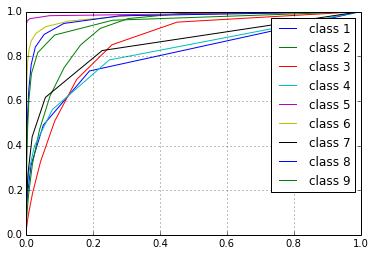

0.904601072094
AUC (new):	

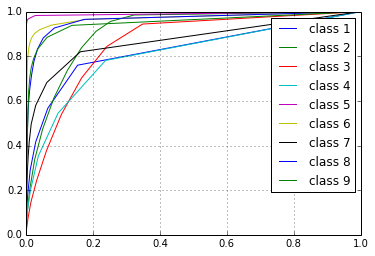

0.90620618222
AUC (newonly):	

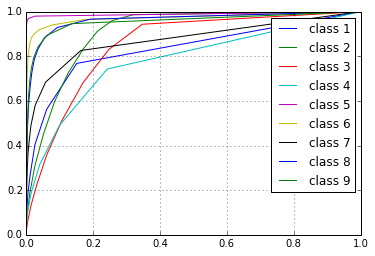

0.90298149373


In [49]:
print 'AUC:\t\t',  multi_roc_auc_score(y_test, rf_clf.predict_proba(X_test))
print 'AUC (new):\t',  multi_roc_auc_score(y_test_new, rf_clf_new.predict_proba(X_test_new))
print 'AUC (newonly):\t',  multi_roc_auc_score(y_test_new, rf_clf_newonly.predict_proba(X_test_newonly))

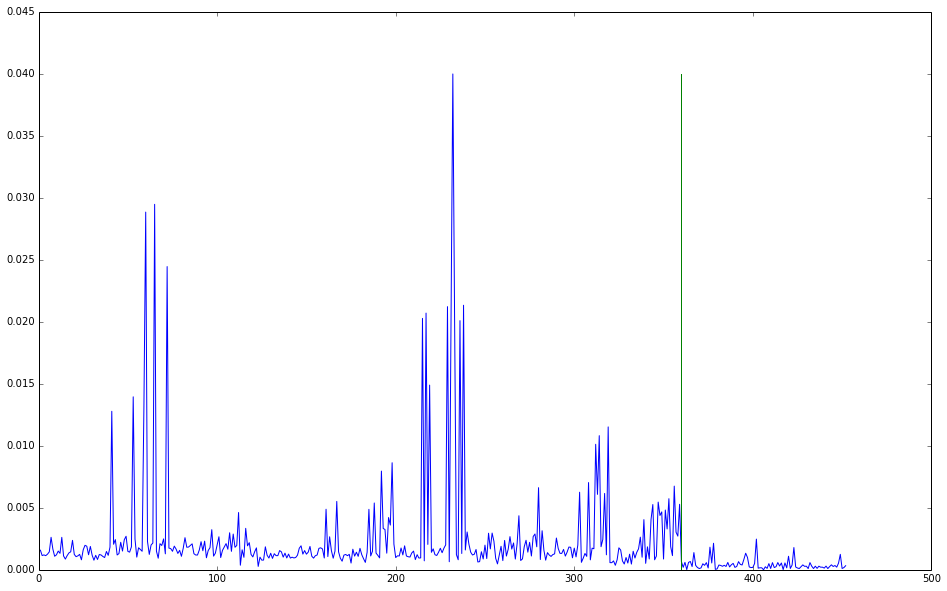

In [50]:
figure(figsize=(16, 10))
plot(rf_clf_new.feature_importances_)
plot([360, 360], [0, 0.04])
show()

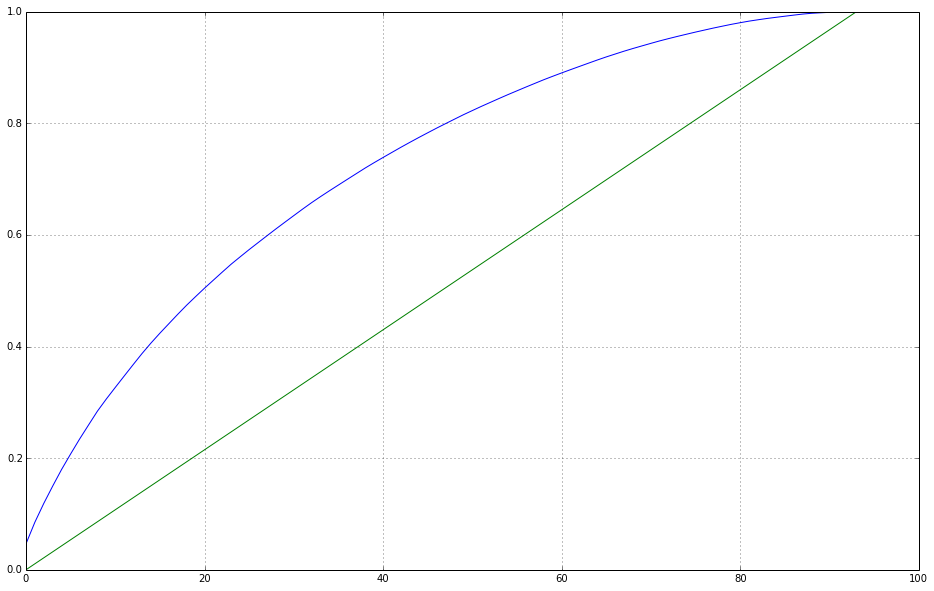

In [65]:
figure(figsize(16, 10))
plot(cumsum(sorted(rf_clf.feature_importances_, reverse=True)))
plot([0, 93], [0, 1])
grid()

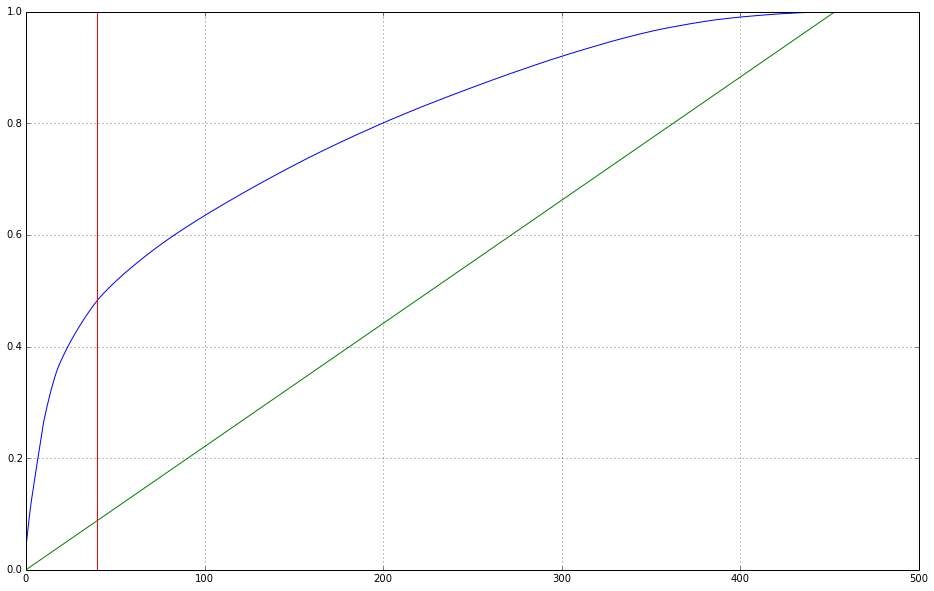

In [63]:
figure(figsize(16, 10))
plot(cumsum(sorted(rf_clf_new.feature_importances_, reverse=True)))
plot([0, 453], [0, 1])
x = 40
grid()
plot([x, x], [0, 1])

In [52]:
?sorted

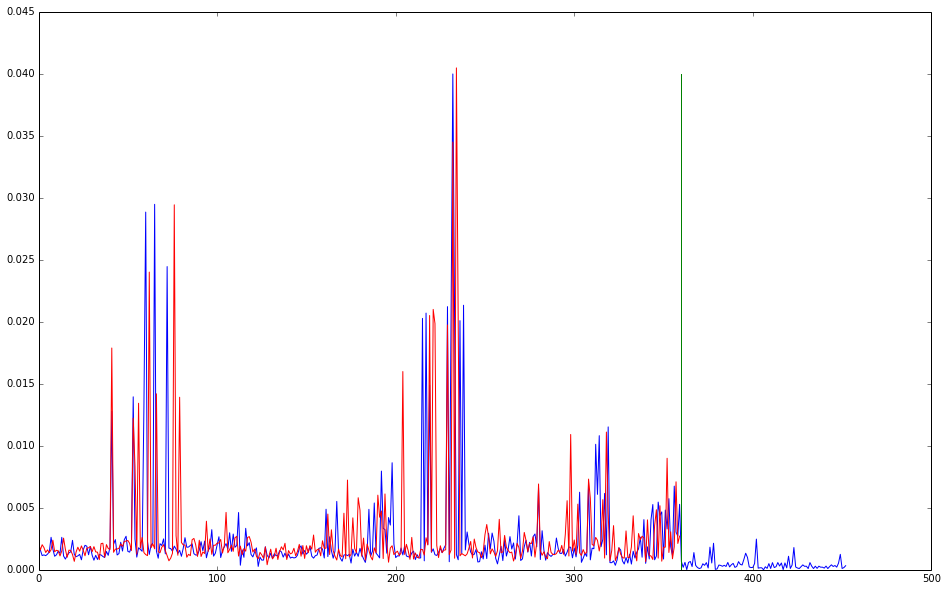

In [171]:
figure(figsize=(16, 10))
plot(rf_clf_new.feature_importances_)
plot([360, 360], [0, 0.04])

plot(rf_clf_newonly.feature_importances_)
show()

In [161]:
rf_clf_new.feature_importances_.shape, rf_clf.feature_importances_.shape

((453,), (93,))

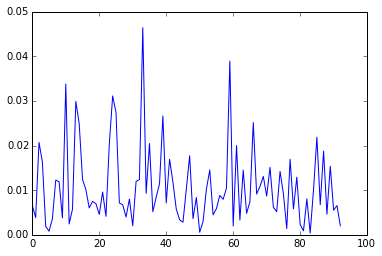

In [153]:
plot(rf_clf.feature_importances_)

In [93]:
mce_old = {}
mce_new = {}
ranges = range(1, 30)

for depth in ranges:
    params = {'n_estimators' : 10,
              'max_depth': depth,
              'random_state' : 0}

    rf_clf = RandomForestClassifier(**params)
    rf_clf.fit(X_train, y_train)

    rf_clf_new = RandomForestClassifier(**params)
    rf_clf_new.fit(X_train_new, y_train_new)
    
    mce_old[depth] = rf_clf.score(X_test, y_test)
    mce_new[depth] = rf_clf_new.score(X_test_new, y_test_new)

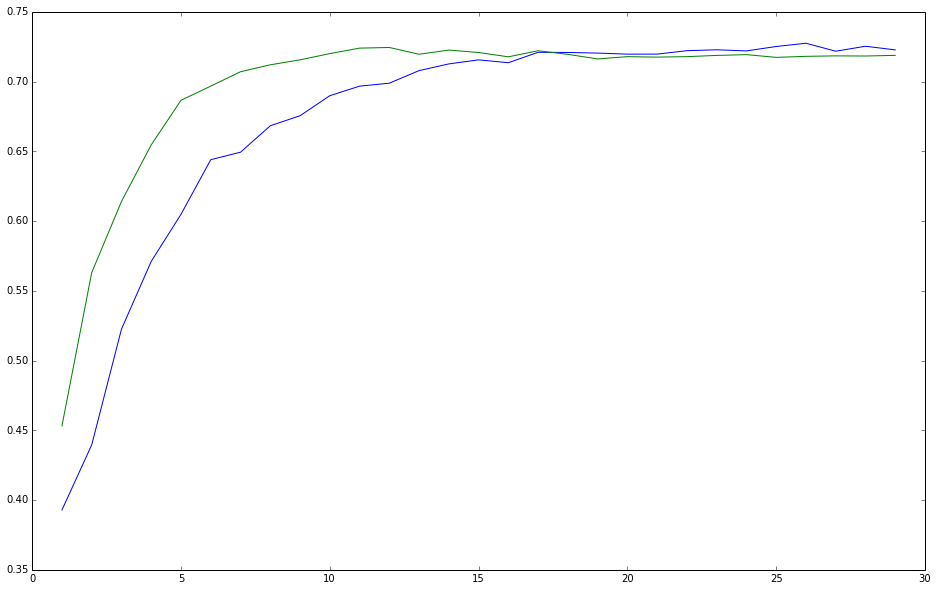

In [94]:
plot(mce_old.keys(), mce_old.values())
plot(mce_new.keys(), mce_new.values())

In [88]:
params = {'n_estimators' : 10,
          'max_depth': 20,
          'random_state' : 0}

rf_clf = RandomForestClassifier(**params)
rf_clf.fit(X_train, y_train)

rf_clf_new = RandomForestClassifier(**params)
rf_clf_new.fit(X_train_new, y_train_new)

rf_clf_newonly = RandomForestClassifier(**params)
rf_clf_newonly.fit(X_train_newonly, y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [89]:
print 'MCE:\t\t',  rf_clf.score(X_test, y_test)
print 'MCE (new):\t',  rf_clf_new.score(X_test_new, y_test_new)
print 'MCE (newonly):\t',  rf_clf_newonly.score(X_test_newonly, y_test_new)

MCE:		0.719651674298
MCE (new):	0.717856180986
MCE (newonly):	0.7139060957


AUC:		

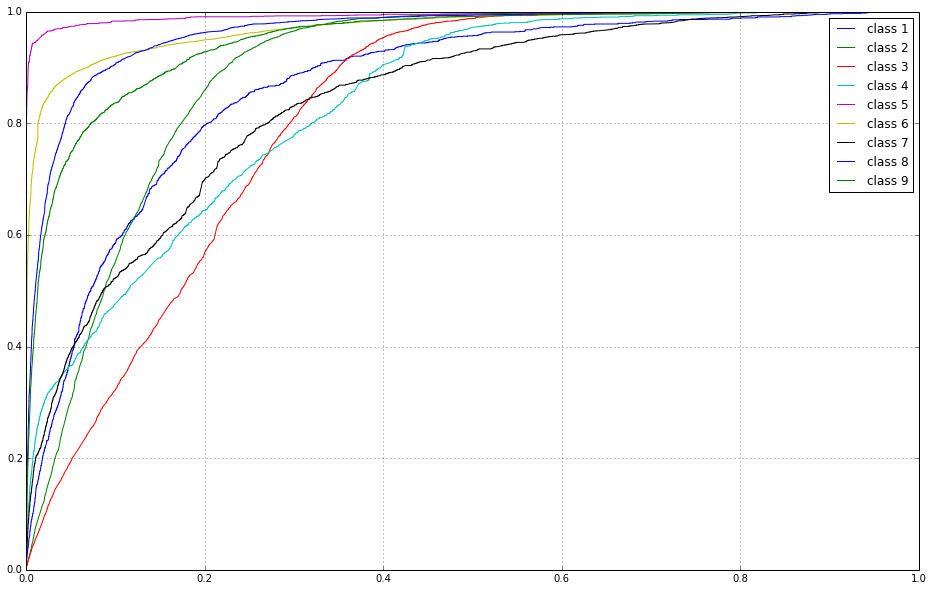

0.903436586672
AUC (new):	

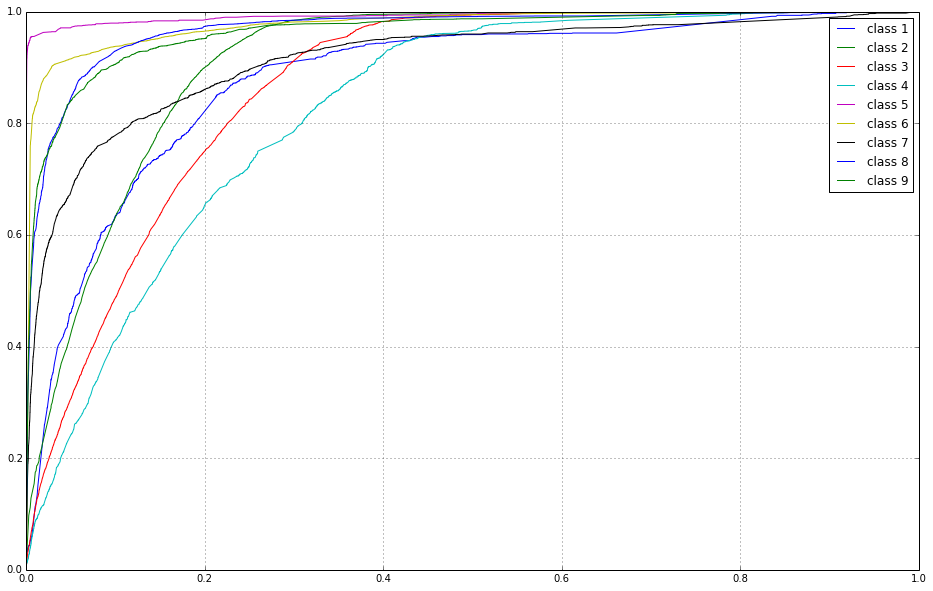

0.922746280191
AUC (newonly):	

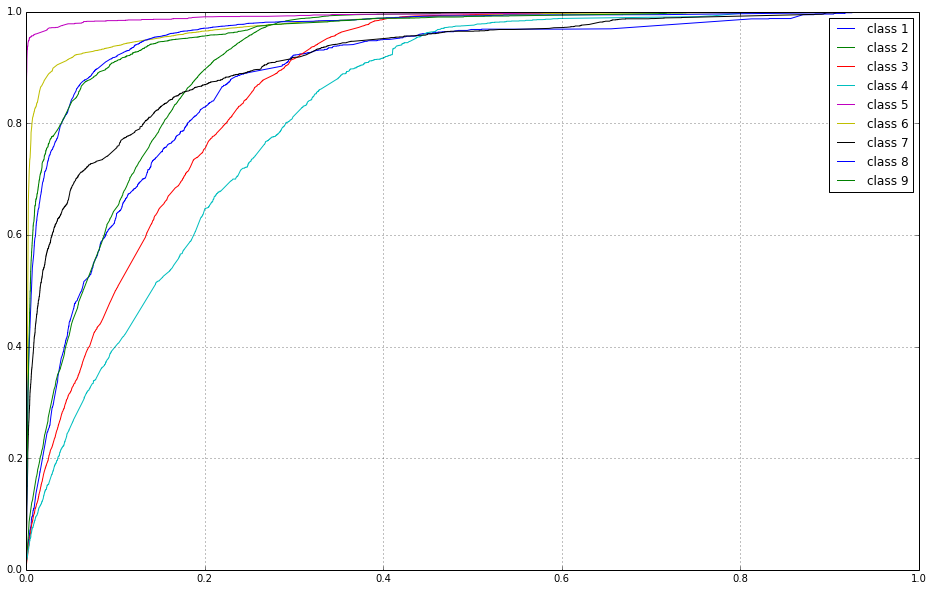

0.924271614133


In [76]:
print 'AUC:\t\t',  multi_roc_auc_score(y_test, rf_clf.predict_proba(X_test))
print 'AUC (new):\t',  multi_roc_auc_score(y_test_new, rf_clf_new.predict_proba(X_test_new))
print 'AUC (newonly):\t',  multi_roc_auc_score(y_test_new, rf_clf_newonly.predict_proba(X_test_newonly))

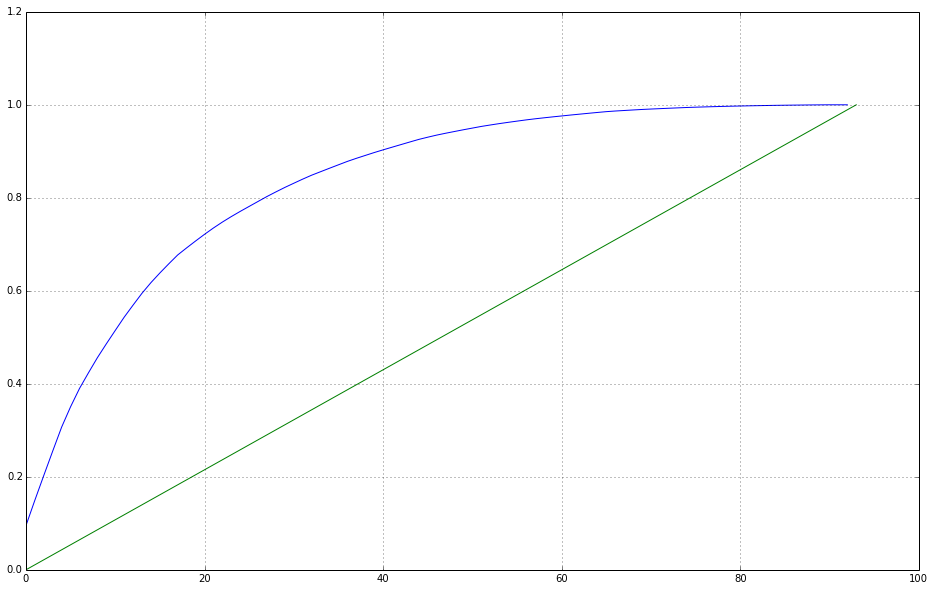

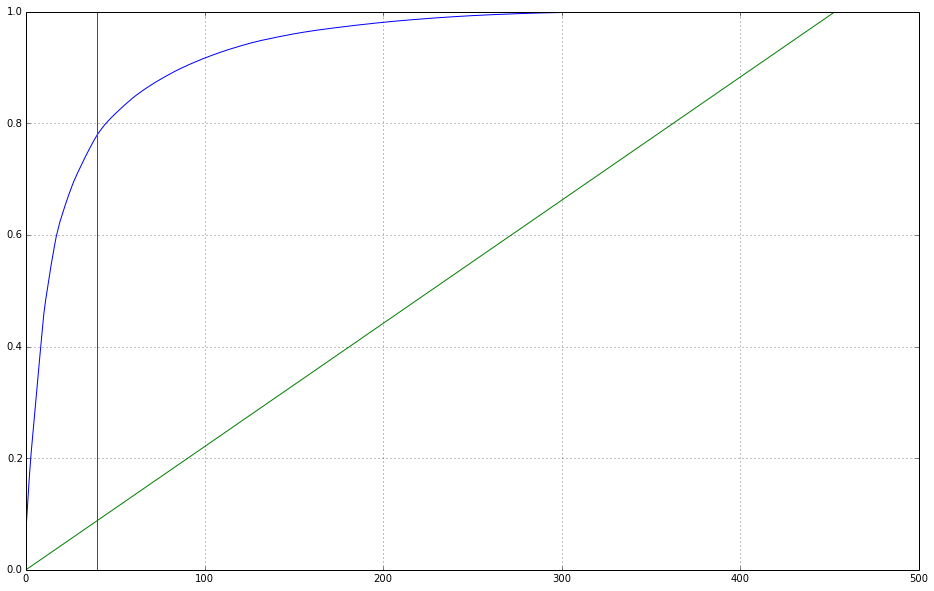

In [77]:
figure(figsize(16, 10))
plot(cumsum(sorted(rf_clf.feature_importances_, reverse=True)))
plot([0, 93], [0, 1])
grid()

figure(figsize(16, 10))
plot(cumsum(sorted(rf_clf_new.feature_importances_, reverse=True)))
plot([0, 453], [0, 1])
x = 40
grid()
plot([x, x], [0, 1])

In [69]:
params = {'n_estimators' : 10,
          'max_depth': None,
          'min_samples_leaf' : 100,
          'random_state' : 0}

rf_clf = RandomForestClassifier(**params)
rf_clf.fit(X_train, y_train)

rf_clf_new = RandomForestClassifier(**params)
rf_clf_new.fit(X_train_new, y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [180]:
print 'MCE:\t\t',  rf_clf.score(X_test, y_test)
print 'MCE (new):\t',  rf_clf_new.score(X_test_new, y_test_new)
print 'MCE (newonly):\t',  rf_clf_newonly.score(X_test_newonly, y_test_new)

MCE:		0.632265014813
MCE (new):	0.683993177125
MCE (newonly):	0.639770176856


AUC:		

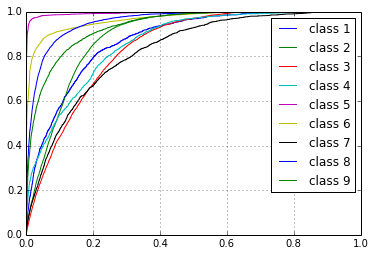

0.904385251542
AUC (new):	

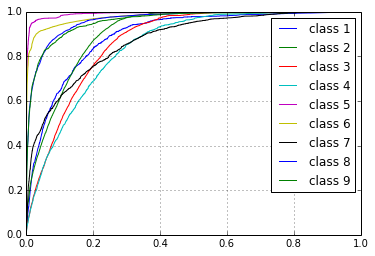

0.919196347728
AUC (newonly):	

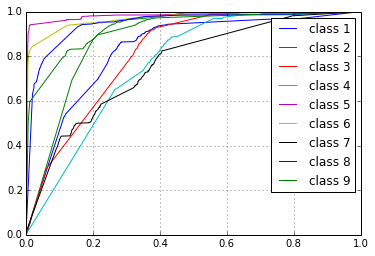

0.875320788778


In [181]:
print 'AUC:\t\t',  multi_roc_auc_score(y_test, rf_clf.predict_proba(X_test))
print 'AUC (new):\t',  multi_roc_auc_score(y_test_new, rf_clf_new.predict_proba(X_test_new))
print 'AUC (newonly):\t',  multi_roc_auc_score(y_test_new, rf_clf_newonly.predict_proba(X_test_newonly))

# Reformat **.tab

In [16]:
def msws_formatize(df, filename):
    df.sort(columns='target')
    target = df['target']
    class_labels = unique(target.values)
    last_idxs = 
    

SyntaxError: invalid syntax (<ipython-input-16-9e542839311b>, line 5)

In [182]:
best[1]

[([16, 24, 29, 53, 59, 66, 70, 83],
  (0.27563797176827881,
   array([ 0.11957204,  0.16090441,  0.01989319,  0.16335619,  0.25976055,
           0.06943133,  0.08227011,  0.12481217]))),
 ([16, 24, 29, 53, 56, 66, 70, 83],
  (0.27570611644912446,
   array([ 0.08218892,  0.10525623,  0.01551146,  0.10952295,  0.50222649,
           0.04703297,  0.05605339,  0.08220759]))),
 ([16, 24, 29, 53, 66, 70, 83, 85, 89],
  (0.27574883144724111,
   array([ 0.10358257,  0.11965248,  0.02244311,  0.15289767,  0.06730552,
           0.06749887,  0.1040218 ,  0.13887704,  0.22372094]))),
 ([16, 24, 29, 53, 54, 57, 66, 83, 85],
  (0.27593017559315658,
   array([ 0.0971092 ,  0.11280483,  0.01967569,  0.15904919,  0.07972876,
           0.2283865 ,  0.06626649,  0.09499731,  0.14198203]))),
 ([16, 24, 29, 53, 54, 59, 66, 83, 84],
  (0.27607477984994067,
   array([ 0.09940863,  0.13205111,  0.01746414,  0.15392705,  0.08255027,
           0.22537886,  0.05602691,  0.09744964,  0.13574339]))),
 ([16, 24

TODO:

* эксперимент с 3000 объектами (5%)
* изначально расширить, затем отбирать